<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_04_Data_Handling_and_Preparation_in_Python_(I).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7 Steps to Machine Learning

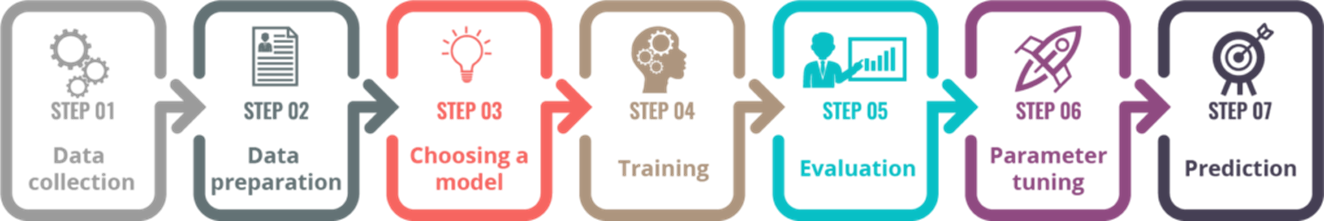

---

# MIMIC-III Example: In-hospital Mortality Prediction

# 1. Objectives

As an example, we hypothesize that patients with a lot of interactions/events/encounters daily within their hospital stay tend to have a higher risk of mortality. Can we build a model that **predicts in-hospital death** for each hospital admission based on those variables?

In machine learning terms, we are trying to build a *binary classification* model using *supervised* learning. 

---

# 2. Setting up

First, let's load up libraries and authenticate ourselves. Apart from *pandas*, we will also import *numpy* for general table-based computations; and *seaborn* for visualisation and plots. 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


---

# 3. Data Preparation: Gathering Data

In this step, we sought to gather all relevant information for each hospital stay across several tables in MIMIC-III. 

| Table | Variables to be extracted |
| --- | --- | 
| `admissions` | The basis of the table. <br>`SUBJECT_ID`, `HADM_ID`, `ADMISSION_TYPE`, <br>`ADMITTIME`, `DISCHTIME`, `DEATHTIME`, `HOSPITAL_EXPIRE_FLAG`, <br>`DIAGNOSIS`, `MARITAL_STATUS`,`INSURANCE`, `LANGUAGE`, `RELIGION`, `ETHNICITY` |
| `patients` | `GENDER`, `DOB` | 
| `icustays` | `LOS` |
| `labevents` | Number of events relating to laboratory tests | 
| `callouts` | Number of callouts of the patients |
| `prescriptions` | Number of prescriptions ordered | 
| `procedures_icd` | Number of procedures received | 
| `inputevents_cv`<br>`inputevents_mv` | Number of fluid input records |
| `outputevents` | Number of fluid output records |
| `diagnosis_icd` | Number of diagnoses | 
| `transfers` | Number of transfers within hospital stay |
| `cptevents` | Number of events recorded in Current Procedural Terminology |
| `microbiologyevents` | Number of microbiology events or tests |


Let's start by writing down a simpler query that counts the number of diagnoses per admission using the `diagnoses_icd` table. Then, include that as an additional column in the `admissions` table (see Exercise 10 in our SQL Tutorial). 

Once again, you can first test the SQL queries in [BigQuery](https://console.cloud.google.com/bigquery) before pasting it in Colab; and you can find your GCP project ID in [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager). 


In [3]:
bigquery_project_id = 'your-project-id-here'
# make sure you change the project ID above!

In [4]:
%%bigquery --project $bigquery_project_id

WITH diags AS (
  SELECT HADM_ID, COUNT(HADM_ID) AS DIAG_COUNT 
  FROM `physionet-data.mimiciii_clinical.diagnoses_icd` 
  GROUP BY HADM_ID
)


SELECT adm.*, diags.DIAG_COUNT
FROM `physionet-data.mimiciii_clinical.admissions` AS adm
LEFT JOIN diags
ON adm.HADM_ID = diags.HADM_ID
LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,DIAG_COUNT
0,3757,3115,134067,2139-02-13 03:11:00,2139-02-20 07:33:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,None,None,WHITE,2139-02-13 00:02:00,2139-02-13 03:22:00,STAB WOUND,0,1,4
1,8689,7124,109129,2188-07-11 00:58:00,2188-08-01 12:04:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,None,None,WHITE,2188-07-10 14:17:00,2188-07-11 01:52:00,PENILE LACERATION-CELLULITIS,0,1,9
2,12652,10348,121510,2133-04-16 21:12:00,2133-04-23 15:52:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,None,None,UNKNOWN/NOT SPECIFIED,2133-04-16 19:22:00,2133-04-16 22:17:00,STATUS EPILEPTICUS,0,1,9
3,11501,9396,106469,2109-02-16 23:14:00,2109-02-23 12:01:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,None,None,WHITE,2109-02-16 20:58:00,2109-02-16 23:42:00,SUBDURAL HEMATOMA,0,1,7
4,11419,9333,133732,2167-10-06 18:35:00,2167-10-16 13:13:00,NaT,URGENT,TRANSFER FROM HOSP/EXTRAM,SNF,Private,None,None,None,UNKNOWN/NOT SPECIFIED,NaT,NaT,CORONARY ARTERY DISEASE,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,26179,21446,155130,2162-11-25 06:16:00,2162-11-27 15:49:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,JEWISH,None,WHITE,NaT,NaT,NEWBORN,0,1,5
996,26797,21941,192427,2184-08-08 09:33:00,2184-08-11 11:55:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,JEWISH,None,ASIAN,NaT,NaT,NEWBORN,0,1,2
997,27584,22621,167007,2178-06-14 21:56:00,2178-06-17 12:20:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,JEWISH,None,WHITE,NaT,NaT,NEWBORN,0,1,1
998,30658,25091,175116,2169-01-08 19:53:00,2169-01-11 17:04:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,JEWISH,None,WHITE,NaT,NaT,NEWBORN,0,1,3


Then, we can write a comprehensive SQL query for retrieving all the information across tables as follows. The query is quite long and complex at first glance, but can be broken down into three key components:

1. Calculate the event counts from each table listed above, except for `admissions`, `patients` and `icustays`. Create alias for each of them using keywords `WITH` and `AS`.
2. Specify the columns we want to retrieve from each table. 
3. Link all the tables to the `admissions` table using `LEFT JOIN`, with either `HADM_ID` or `SUBJECT_ID` as the common column. 

We save the query results to a Python variable named `df`. 

In [5]:
%%bigquery df --project $bigquery_project_id

# 1. 
WITH 
icustay AS (SELECT HADM_ID, SUM(LOS) AS LOS_ICU FROM `physionet-data.mimiciii_clinical.icustays` GROUP BY HADM_ID), 
callout AS (SELECT HADM_ID, COUNT(HADM_ID) AS CALLOUT_COUNT FROM  `physionet-data.mimiciii_clinical.callout` GROUP BY HADM_ID),
diags AS (SELECT HADM_ID, COUNT(HADM_ID) AS DIAG_COUNT FROM `physionet-data.mimiciii_clinical.diagnoses_icd` GROUP BY HADM_ID),
preps AS (SELECT HADM_ID, COUNT(HADM_ID) AS PRES_COUNT FROM `physionet-data.mimiciii_clinical.prescriptions` GROUP BY HADM_ID),
procs AS (SELECT HADM_ID, COUNT(HADM_ID) AS PROC_COUNT FROM `physionet-data.mimiciii_clinical.procedures_icd` GROUP BY HADM_ID),
cpts AS (SELECT HADM_ID, COUNT(HADM_ID) AS CPT_COUNT FROM `physionet-data.mimiciii_clinical.cptevents` GROUP BY HADM_ID),
labs AS (SELECT HADM_ID, COUNT(HADM_ID) AS LAB_COUNT FROM `physionet-data.mimiciii_clinical.labevents` GROUP BY HADM_ID),
inputs_cv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_CV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_cv` GROUP BY HADM_ID),
inputs_mv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_MV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_mv` GROUP BY HADM_ID),
outputs AS (SELECT HADM_ID, COUNT(HADM_ID) AS OUTPUT_COUNT FROM `physionet-data.mimiciii_clinical.outputevents` GROUP BY HADM_ID),
transfers AS (SELECT HADM_ID, COUNT(HADM_ID) AS TRANSFER_COUNT FROM `physionet-data.mimiciii_clinical.transfers` GROUP BY HADM_ID),
micros AS (SELECT HADM_ID, COUNT(HADM_ID) AS MICRO_COUNT FROM `physionet-data.mimiciii_clinical.microbiologyevents` GROUP BY HADM_ID)

# 2. 
SELECT adm.SUBJECT_ID, adm.HADM_ID, adm.ADMISSION_TYPE, 
adm.ADMITTIME, adm.DISCHTIME, adm.DEATHTIME, adm.HOSPITAL_EXPIRE_FLAG, 
adm.DIAGNOSIS, adm.MARITAL_STATUS, adm.INSURANCE, adm.LANGUAGE, adm.RELIGION, adm.ETHNICITY,
pts.GENDER, pts.DOB, icustay.LOS_ICU, callout.CALLOUT_COUNT, diags.DIAG_COUNT, 
preps.PRES_COUNT, procs.PROC_COUNT, cpts.CPT_COUNT, labs.LAB_COUNT, 
inputs_cv.INPUTS_CV_COUNT, inputs_mv.INPUTS_MV_COUNT, outputs.OUTPUT_COUNT, 
transfers.TRANSFER_COUNT, micros.MICRO_COUNT

# 3. 
FROM `physionet-data.mimiciii_clinical.admissions` AS adm
LEFT JOIN `physionet-data.mimiciii_clinical.patients` AS pts on adm.SUBJECT_ID = pts.SUBJECT_ID
LEFT JOIN icustay on adm.HADM_ID = icustay.HADM_ID
LEFT JOIN callout on adm.HADM_ID = callout.HADM_ID
LEFT JOIN diags on adm.HADM_ID = diags.HADM_ID
LEFT JOIN preps on adm.HADM_ID = preps.HADM_ID
LEFT JOIN procs on adm.HADM_ID = procs.HADM_ID
LEFT JOIN cpts on adm.HADM_ID = cpts.HADM_ID
LEFT JOIN labs on adm.HADM_ID = labs.HADM_ID
LEFT JOIN inputs_cv on adm.HADM_ID = inputs_cv.HADM_ID
LEFT JOIN inputs_mv on adm.HADM_ID = inputs_mv.HADM_ID
LEFT JOIN outputs on adm.HADM_ID = outputs.HADM_ID
LEFT JOIN transfers on adm.HADM_ID = transfers.HADM_ID
LEFT JOIN micros on adm.HADM_ID = micros.HADM_ID

Query is running:   0%|          |

Downloading:   0%|          |

Let's have a quick look of the gathered dataset.

In [6]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,DIAGNOSIS,MARITAL_STATUS,INSURANCE,...,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT
0,3115,134067,EMERGENCY,2139-02-13 03:11:00,2139-02-20 07:33:00,NaT,0,STAB WOUND,None,Medicare,...,4,<NA>,4,<NA>,346,736,<NA>,138,4,14
1,7124,109129,EMERGENCY,2188-07-11 00:58:00,2188-08-01 12:04:00,NaT,0,PENILE LACERATION-CELLULITIS,None,Medicare,...,9,<NA>,6,11,753,712,<NA>,194,4,57
2,10348,121510,EMERGENCY,2133-04-16 21:12:00,2133-04-23 15:52:00,NaT,0,STATUS EPILEPTICUS,None,Medicare,...,9,<NA>,3,<NA>,124,235,<NA>,24,4,3
3,9396,106469,EMERGENCY,2109-02-16 23:14:00,2109-02-23 12:01:00,NaT,0,SUBDURAL HEMATOMA,None,Medicare,...,7,<NA>,1,<NA>,138,90,<NA>,48,3,<NA>
4,9333,133732,URGENT,2167-10-06 18:35:00,2167-10-16 13:13:00,NaT,0,CORONARY ARTERY DISEASE,None,Private,...,4,<NA>,2,<NA>,315,857,<NA>,138,5,1


We could also print some general information of the dataframe using `.info()`. Here, the datatype 'object' would imply string/text in most of your use cases. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            58976 non-null  Int64         
 1   HADM_ID               58976 non-null  Int64         
 2   ADMISSION_TYPE        58976 non-null  object        
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   datetime64[ns]
 6   HOSPITAL_EXPIRE_FLAG  58976 non-null  Int64         
 7   DIAGNOSIS             58951 non-null  object        
 8   MARITAL_STATUS        48848 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  ETHNICITY             58976 non-null  object        
 13  GENDER          

`.isna().sum()` calculates the number of missing entries per column. We could see from the following that there are missing values in several columns, which could be problematic in training machine learning models. 

In [8]:
df.isna().sum()

SUBJECT_ID                  0
HADM_ID                     0
ADMISSION_TYPE              0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
HOSPITAL_EXPIRE_FLAG        0
DIAGNOSIS                  25
MARITAL_STATUS          10128
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
ETHNICITY                   0
GENDER                      0
DOB                         0
LOS_ICU                  1200
CALLOUT_COUNT           30244
DIAG_COUNT                  0
PRES_COUNT               8760
PROC_COUNT               6733
CPT_COUNT               14828
LAB_COUNT                 825
INPUTS_CV_COUNT         27006
INPUTS_MV_COUNT         37097
OUTPUT_COUNT             6968
TRANSFER_COUNT              0
MICRO_COUNT             10236
dtype: int64

`.describe()` for some generic statistics for numerical columns:

In [9]:
df.describe()

,SUBJECT_ID,HADM_ID,HOSPITAL_EXPIRE_FLAG,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT
count,58976.000000,58976.000000,58976.000000,57776.000000,28732.000000,58976.000000,50216.000000,52243.000000,44148.000000,58151.000000,31970.000000,21879.000000,52008.000000,58976.000000,48740.000000
mean,33755.583288,149970.809584,0.099261,5.236836,1.200717,11.039185,82.771427,4.595735,12.982377,382.539148,547.552893,165.409342,83.532899,4.440739,12.961141
std,28092.726225,28883.095213,0.299014,10.113915,0.517605,6.466180,75.012547,3.823601,18.045047,504.397394,1200.334370,340.026862,149.437728,1.843467,22.499347
min,2.000000,100001.000000,0.000000,0.000200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,11993.750000,124952.750000,0.000000,1.122400,1.000000,6.000000,35.000000,2.000000,4.000000,122.000000,52.000000,23.000000,16.000000,3.000000,1.000000
50%,24133.500000,149989.500000,0.000000,2.149950,1.000000,9.000000,65.000000,3.000000,7.000000,238.000000,160.000000,58.000000,39.000000,4.000000,4.000000
75%,53851.500000,174966.500000,0.000000,4.877475,1.000000,15.000000,105.000000,6.000000,15.000000,437.000000,460.000000,147.000000,86.000000,5.000000,15.000000
max,99999.000000,199999.000000,1.000000,260.708900,7.000000,39.000000,1400.000000,40.000000,362.000000,13713.000000,40130.000000,7009.000000,6883.000000,25.000000,565.000000


---

# 4. Data Preparation: Pre-processing Data

Now, we want to pre-process the data such that it is ready to be fed into a model. We also want to make our variables as useful as possible for the model to learn from, a.k.a. *feature engineering*. Typically, there are 5 types of feature engineering:

* **Creating** <br> Derive new features from existing ones if they provide **additional value** when predicting our outcome (e.g. age from date of birth and admission; pulse pressure from the difference between systolic and diastolic blood pressures). <br>-
* **Converting** <br> The raw dataset is most probably not ready for direct modelling. Some features need to be converted or normalized to **meet the model input requirements**. Before we feed the training dataset into our model, we usually need to convert all datatypes to numerical values for mathematical computation. <br>-
* **Completing** <br> Most models require no **missing values** in input variables in order to work. Some other model algorithms work best when there are no missing values. If missing values exist in the dataset, we may need to handle them either by (i) filling in any missing values through estimation; (ii) excluding the variable as an input; (iii) excluding the learning samples with any missing value present. Working with a clinician could be very helpful in this regard to help you figure out what are the important variables to keep in a dataset. <br>-
* **Correcting** <br> We may also come across **errors or inaccurate values** or even **duplicated entries** within a dataset. Try to correct these values or exclude the problematic samples with errors. One way to identify them is to look out for any outliers among features, or to perform Exploratory Data Analysis. <br>-
* **Correlating** <br> Having overly **redundant information** within the input variable set would not help the model training process and could sometimes even lead to worse performances. One thing we can do is to perform basic statistical analysis. Which features within the dataset contribute significantly to our target variable? This can be tested both for numerical and categorical features in the given dataset.

When approaching a new dataset, we have to try our best to understand it, go through each column and identify the corresponding pre-processing procedures.

In the case of `df`, we outline these pre-processing steps as an example:
* Creating
  * A column depicting in-hospital death
  * Age at admission
  * Hospital length of stay
* Correcting
  * Age at admission
  * Hospital length of stay
* Converting
  * Normalising count-based features
* Completing
  * Numerical features
  * Categorical features


---

## 4.1 Creating



### In-hospital death

As `HOSPITAL_EXPIRE_FLAG` indicates in-hospital death (see [MIMIC's documentation](https://mimic.physionet.org/about/mimic/)), it will be our **prediction target**.<br>Let's rename the variable `HOSPITAL_EXPIRE_FLAG` into a more descriptive/semantic one, `IN_HOSP_DEATH`.

To create a new column in a given dataframe, simply specify the new column name and assign (`=`) a Series of values to it. 

In [10]:
df['IN_HOSP_DEATH'] = df['HOSPITAL_EXPIRE_FLAG']

In [11]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'MARITAL_STATUS',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'CALLOUT_COUNT', 'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT',
       'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT',
       'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT', 'IN_HOSP_DEATH'],
      dtype='object')

We can then remove the redundant column `HOSPITAL_EXPIRE_FLAG`.

In [12]:
df = df.drop(columns = 'HOSPITAL_EXPIRE_FLAG')

In [12]:
df['HOSPITAL_EXPIRE_FLAG'] # results in an error as the column no longer exists

KeyError: ignored

In [ ]:
# Alternatively, we can simply use the function `DataFrame.rename()` instead of creating and removing
# df = df.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'IN_HOSP_DEATH'})

Also note that it is already numeric (either 1 or 0) and has no missing values, thus can be used as is for model training.

In [13]:
df['IN_HOSP_DEATH'].isna().sum()

0

In [14]:
df['IN_HOSP_DEATH'].value_counts()

0    53122
1     5854
Name: IN_HOSP_DEATH, dtype: Int64

#### Age at admission

We don't have a column indicating age, which is a crucial factor in most clinical research questions and decision systems. However, we can calculate it based on `DOB` (Date of birth) and `ADMITTIME`. Let's first make new columns to convert the data types of `ADMITTIME` from datetime to date.


In [15]:
df[['ADMITTIME', 'DOB']].head()

,ADMITTIME,DOB
0,2139-02-13 03:11:00,2096-06-07
1,2188-07-11 00:58:00,2135-11-25
2,2133-04-16 21:12:00,2049-06-08
3,2109-02-16 23:14:00,1809-02-16
4,2167-10-06 18:35:00,2107-03-10


In [16]:
df['date_of_admission'] = df['ADMITTIME'].dt.date
df['DOB'] = df['DOB'].dt.date

In [17]:
df[['date_of_admission', 'DOB']].head()

,date_of_admission,DOB
0,2139-02-13,2096-06-07
1,2188-07-11,2135-11-25
2,2133-04-16,2049-06-08
3,2109-02-16,1809-02-16
4,2167-10-06,2107-03-10


They are now comparable! We then subtract `DOB` from `ADMITTIME`, then express the difference in years.

In [18]:
df['AGE'] = ((df['date_of_admission'] - df['DOB']) // 365).dt.days
# Integer division (`//`) is used

In [19]:
df['AGE']

0         42
1         52
2         83
3        300
4         60
        ... 
58971     82
58972     44
58973     65
58974     83
58975     83
Name: AGE, Length: 58976, dtype: int64

Let's have a quick look of the results. 

In [20]:
df['AGE'].describe()

count    58976.000000
mean        64.053361
std         57.203724
min          0.000000
25%         43.000000
50%         61.000000
75%         75.000000
max        311.000000
Name: AGE, dtype: float64

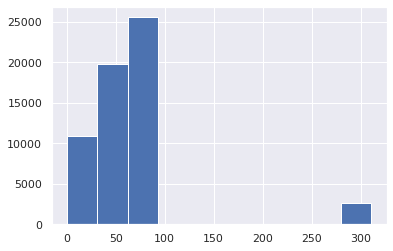

In [21]:
df['AGE'].hist()

You may notice some weird values. We will address this later in the **Correcting** section.

#### Hospital length of stay

Likewise, we can create a variable indicating hospital length of stay.

In [22]:
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']) / np.timedelta64(1,'D') 
# subtract `ADMITTIME` from `DISCHTIME`, and express difference in days ('D'). 
# Division (`/`) is used.

df['LOS']

0         7.181944
1        21.462500
2         6.777778
3         6.532639
4         9.776389
           ...    
58971     3.936806
58972    15.786806
58973    16.442361
58974     4.561111
58975     4.737500
Name: LOS, Length: 58976, dtype: float64

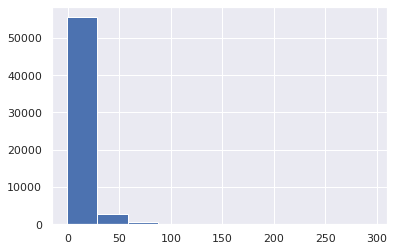

In [23]:
df['LOS'].hist()

If you can think of any other variables that can be useful, feel free to add them by yourselves!

---

## 4.2 Correcting

### Age at admission

As we have seen previously, the age column contains certain suspicious values. Why is that?

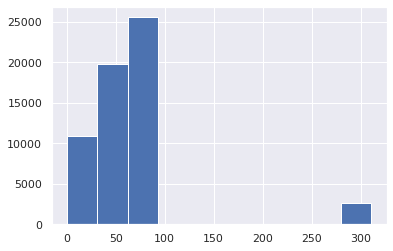

In [24]:
df['AGE'].hist()

In [25]:
df.loc[df['AGE'] > 150, ['SUBJECT_ID', 'AGE']] 
# select rows that satisfy df['AGE'] > 150; and the columns 'SUBJECT_ID' and 'AGE'. 

,SUBJECT_ID,AGE
3,9396,300
78,9922,300
99,21681,300
122,14960,300
123,21272,300
...,...,...
58903,12289,300
58920,12289,304
58921,28815,300
58941,68863,300


A number of measures were performed to protect patient privacy. Quoting from [MIMIC-III's documentation](https://mimic.mit.edu/docs/iii/about/time/), 

> All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future.

> Dates of birth which occur in the present time are not true dates of birth. Furthermore, dates of birth which occur before the year 1900 occur if the patient is older than 89. In these cases, the patient’s age at their first admission has been fixed to 300.

In other words, the true age of all patients with an imputed age of 300 are in fact censored. All we know is that they were older than 89. For illustration, let's simply set them to be 90.

In [26]:
df.loc[df['AGE'] > 150, 'AGE'] = 90  # select rows that satisfy df['AGE'] > 150; and the column 'AGE'. Set them to 90

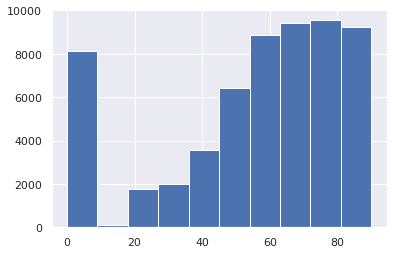

In [27]:
df['AGE'].hist()

Note that the ~8,000 admissions centered around 0 refers to newborns. You may or may not keep them depending on the goals of your model. 

### Hospital length of stay

When we closely examine the `LOS` variable we created, there are entries with negative LOS. Let's us set the minimum LOS to be 1 day. 

In [28]:
df['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [29]:
df.loc[df['LOS'] < 1, 'LOS'] = 1 
# select rows that satisfy df['LOS'] < 1; and the column 'LOS'. Set them to 90

In [30]:
df['LOS'].describe()

count    58976.000000
mean        10.152970
std         12.442141
min          1.000000
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

---

## 4.3 Converting

As length of stay varies a lot across patients, using the daily count of events could be a more accurate depiction of severity than total events across the entire hospital stay. 

Here, we may normalize the total count values into daily average count values by computing the values and saving them as new columns. We would also append '_DAY' to the column names.

In [31]:
for col_name in ['CALLOUT_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name + '_DAY'] = df[col_name] / df['LOS']

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SUBJECT_ID           58976 non-null  Int64         
 1   HADM_ID              58976 non-null  Int64         
 2   ADMISSION_TYPE       58976 non-null  object        
 3   ADMITTIME            58976 non-null  datetime64[ns]
 4   DISCHTIME            58976 non-null  datetime64[ns]
 5   DEATHTIME            5854 non-null   datetime64[ns]
 6   DIAGNOSIS            58951 non-null  object        
 7   MARITAL_STATUS       48848 non-null  object        
 8   INSURANCE            58976 non-null  object        
 9   LANGUAGE             33644 non-null  object        
 10  RELIGION             58518 non-null  object        
 11  ETHNICITY            58976 non-null  object        
 12  GENDER               58976 non-null  object        
 13  DOB                  58976 non-

In [33]:
df[['LOS', 'PROC_COUNT', 'PROC_COUNT_DAY']].head()

,LOS,PROC_COUNT,PROC_COUNT_DAY
0,7.181944,4,0.556952
1,21.462500,6,0.279557
2,6.777778,3,0.442623
3,6.532639,1,0.153077
4,9.776389,2,0.204575


Note that we did not normalize the column `DIAG_COUNT` just like the others. Why?

---

## 4.4 Completing

### Numerical features

Regarding the features related to counts and counts per day, we can simply fill all missing (presented as `NaN`) values with 0.

Recall that as we are using `LEFT JOIN`, a missing value in these columns means that there are no corresponding entries, which is equivalent to a count of 0. 

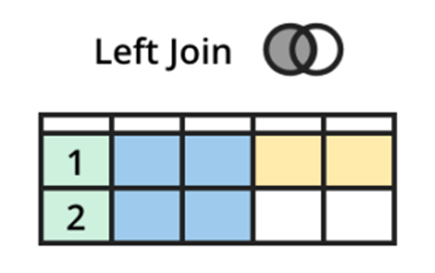

In [34]:
df[['DIAG_COUNT', 'MICRO_COUNT', 'MICRO_COUNT_DAY', 'PRES_COUNT', 'PRES_COUNT_DAY']].head()

,DIAG_COUNT,MICRO_COUNT,MICRO_COUNT_DAY,PRES_COUNT,PRES_COUNT_DAY
0,4,14,1.949333,<NA>,<NA>
1,9,57,2.655795,<NA>,<NA>
2,9,3,0.442623,<NA>,<NA>
3,7,<NA>,<NA>,<NA>,<NA>
4,4,1,0.102287,<NA>,<NA>


In [35]:
df['DIAG_COUNT'] = df['DIAG_COUNT'].fillna(0)
df['LOS_ICU'] = df['LOS_ICU'].fillna(0)

In [36]:
for col_name in ['CALLOUT_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name] = df[col_name].fillna(0) # .fillna() replaces all the missing values of that column with a value you specify
  df[col_name + '_DAY'] = df[col_name + '_DAY'].fillna(0)

In [37]:
df[['DIAG_COUNT', 'MICRO_COUNT', 'MICRO_COUNT_DAY', 'PRES_COUNT', 'PRES_COUNT_DAY']].head()

,DIAG_COUNT,MICRO_COUNT,MICRO_COUNT_DAY,PRES_COUNT,PRES_COUNT_DAY
0,4,14,1.949333,0,0.0
1,9,57,2.655795,0,0.0
2,9,3,0.442623,0,0.0
3,7,0,0.0,0,0.0
4,4,1,0.102287,0,0.0


---

### Categorical features

Going through `df.info()`, there are three categorical variables containing missing values.

In [38]:
df.isna().sum()

SUBJECT_ID                 0
HADM_ID                    0
ADMISSION_TYPE             0
ADMITTIME                  0
DISCHTIME                  0
DEATHTIME              53122
DIAGNOSIS                 25
MARITAL_STATUS         10128
INSURANCE                  0
LANGUAGE               25332
RELIGION                 458
ETHNICITY                  0
GENDER                     0
DOB                        0
LOS_ICU                    0
CALLOUT_COUNT              0
DIAG_COUNT                 0
PRES_COUNT                 0
PROC_COUNT                 0
CPT_COUNT                  0
LAB_COUNT                  0
INPUTS_CV_COUNT            0
INPUTS_MV_COUNT            0
OUTPUT_COUNT               0
TRANSFER_COUNT             0
MICRO_COUNT                0
IN_HOSP_DEATH              0
date_of_admission          0
AGE                        0
LOS                        0
CALLOUT_COUNT_DAY          0
PRES_COUNT_DAY             0
PROC_COUNT_DAY             0
CPT_COUNT_DAY              0
LAB_COUNT_DAY 

In [39]:
df.isna().any() # isna().any() allows you to inspect which column(s) contains at least 1 missing value

SUBJECT_ID             False
HADM_ID                False
ADMISSION_TYPE         False
ADMITTIME              False
DISCHTIME              False
DEATHTIME               True
DIAGNOSIS               True
MARITAL_STATUS          True
INSURANCE              False
LANGUAGE                True
RELIGION                True
ETHNICITY              False
GENDER                 False
DOB                    False
LOS_ICU                False
CALLOUT_COUNT          False
DIAG_COUNT             False
PRES_COUNT             False
PROC_COUNT             False
CPT_COUNT              False
LAB_COUNT              False
INPUTS_CV_COUNT        False
INPUTS_MV_COUNT        False
OUTPUT_COUNT           False
TRANSFER_COUNT         False
MICRO_COUNT            False
IN_HOSP_DEATH          False
date_of_admission      False
AGE                    False
LOS                    False
CALLOUT_COUNT_DAY      False
PRES_COUNT_DAY         False
PROC_COUNT_DAY         False
CPT_COUNT_DAY          False
LAB_COUNT_DAY 

**`MARITAL_STATUS`**: fill in the default value

In [40]:
df['MARITAL_STATUS'].value_counts(dropna = False) 
# by specifying dropna = False, the function counts the number of NaN too

MARRIED              24239
SINGLE               13254
NaN                  10128
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [41]:
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

In [42]:
df['MARITAL_STATUS'].value_counts(dropna = False) # no more NaN's!

MARRIED              24239
SINGLE               13254
UNKNOWN (DEFAULT)    10473
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

**`RELIGION`**: fill in 'NOT SPECIFIED'

In [43]:
df['RELIGION'].value_counts(dropna = False)

CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
NaN                         458
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [44]:
df['RELIGION'] = df['RELIGION'].fillna('NOT SPECIFIED')

In [45]:
df['RELIGION'].value_counts(dropna = False) # no more NaN's!

CATHOLIC                  20606
NOT SPECIFIED             12211
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

**`LANGUAGE`**: fill in the most frequent value

As an example, we will fill in the most frequent value. You may consider other approaches too such as creating a new category of its own or discarding the variable.

In [46]:
df['LANGUAGE'].value_counts(dropna = False)

ENGL    29086
NaN     25332
SPAN     1083
RUSS      790
PTUN      628
        ...  
*LIT        1
* FU        1
*ROM        1
SERB        1
*TAM        1
Name: LANGUAGE, Length: 76, dtype: int64

In [47]:
df['LANGUAGE'] = df['LANGUAGE'].fillna('ENGL')

In [48]:
df['LANGUAGE'].value_counts(dropna = False) # no more NaN's!

ENGL    54418
SPAN     1083
RUSS      790
PTUN      628
CANT      413
        ...  
*LIT        1
* FU        1
*ROM        1
SERB        1
*TAM        1
Name: LANGUAGE, Length: 75, dtype: int64

Now, we can see that the only columns with missing values is `DEATHTIME` and `DIAGNOSIS`. We can leave it as is as they would not be used as predictors in the model in this tutorial (`DIAGNOSIS` is a text-based column which requires further processing; and having `DEATHTIME` would make little sense).

In [49]:
df.isna().any()

SUBJECT_ID             False
HADM_ID                False
ADMISSION_TYPE         False
ADMITTIME              False
DISCHTIME              False
DEATHTIME               True
DIAGNOSIS               True
MARITAL_STATUS         False
INSURANCE              False
LANGUAGE               False
RELIGION               False
ETHNICITY              False
GENDER                 False
DOB                    False
LOS_ICU                False
CALLOUT_COUNT          False
DIAG_COUNT             False
PRES_COUNT             False
PROC_COUNT             False
CPT_COUNT              False
LAB_COUNT              False
INPUTS_CV_COUNT        False
INPUTS_MV_COUNT        False
OUTPUT_COUNT           False
TRANSFER_COUNT         False
MICRO_COUNT            False
IN_HOSP_DEATH          False
date_of_admission      False
AGE                    False
LOS                    False
CALLOUT_COUNT_DAY      False
PRES_COUNT_DAY         False
PROC_COUNT_DAY         False
CPT_COUNT_DAY          False
LAB_COUNT_DAY 

In [50]:
df[['DEATHTIME', 'DIAGNOSIS']].head()

,DEATHTIME,DIAGNOSIS
0,NaT,STAB WOUND
1,NaT,PENILE LACERATION-CELLULITIS
2,NaT,STATUS EPILEPTICUS
3,NaT,SUBDURAL HEMATOMA
4,NaT,CORONARY ARTERY DISEASE


## 4.5 Encoding for Categorical Variables (Converting)

Most categorical variables contains text which usually cannot be directly used as model inputs. We have to convert them using either *Label encoding* or *one-hot encoding*. *Label encoding* represents each category as a distinct number, whereas one-hot coding represents each category as multiple binary variables, spanning across multiple columns.

![encodings](https://miro.medium.com/max/3000/0*T5jaa2othYfXZX9W.)

As a rule of thumb, *one-hot encoding* is better in most cases so that the machine learning model would not treat the encoded values as numerical features. However, tree-based model such as random forest can work with label encoding.

To perform label encoding, we can apply the Scikit-Learn package and use `LabelEncoder()`. For one-hot encoding, you can use the `pd.get_dummies()` function from pandas. Let's look at a few examples. 

### **`ADMISSION_TYPE`**

In [51]:
tmp_df_admissions = pd.get_dummies(df['ADMISSION_TYPE'], prefix = 'ADMISSION_TYPE')

In [52]:
tmp_df_admissions

,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,1
...,...,...,...,...
58971,0,1,0,0
58972,0,1,0,0
58973,0,1,0,0
58974,0,1,0,0


In [53]:
df = pd.concat([df, tmp_df_admissions], axis = 1) 
# combine the above temporary dataframe with the original dataframe
# axis = 1 specifies that we want to stack them horizontally not vertically

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SUBJECT_ID                58976 non-null  Int64         
 1   HADM_ID                   58976 non-null  Int64         
 2   ADMISSION_TYPE            58976 non-null  object        
 3   ADMITTIME                 58976 non-null  datetime64[ns]
 4   DISCHTIME                 58976 non-null  datetime64[ns]
 5   DEATHTIME                 5854 non-null   datetime64[ns]
 6   DIAGNOSIS                 58951 non-null  object        
 7   MARITAL_STATUS            58976 non-null  object        
 8   INSURANCE                 58976 non-null  object        
 9   LANGUAGE                  58976 non-null  object        
 10  RELIGION                  58976 non-null  object        
 11  ETHNICITY                 58976 non-null  object        
 12  GENDER            

### **`GENDER`**

As the column only takes on two values 'M' and 'F', it is easier to simply do a logical operation and save the results as a new column. 

In [55]:
df['GENDER'].value_counts()

M    32950
F    26026
Name: GENDER, dtype: int64

In [56]:
df['GENDER_F'] = (df['GENDER'] == 'F') * 1

In [57]:
df['GENDER_F'].value_counts()

0    32950
1    26026
Name: GENDER_F, dtype: int64

### **`RELIGION`**

The column contains several categories but many of them have a limited sample size and may have limited impact for model training. In this case, it is advisable to retain the most prevalent categories and group the rest into an 'OTHERS' category before one-hot encoding.

In [58]:
df['RELIGION'].value_counts()

CATHOLIC                  20606
NOT SPECIFIED             12211
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [59]:
df['RELIGION']

0              NOT SPECIFIED
1              NOT SPECIFIED
2              NOT SPECIFIED
3              NOT SPECIFIED
4              NOT SPECIFIED
                ...         
58971      PROTESTANT QUAKER
58972      PROTESTANT QUAKER
58973      PROTESTANT QUAKER
58974    CHRISTIAN SCIENTIST
58975    CHRISTIAN SCIENTIST
Name: RELIGION, Length: 58976, dtype: object

In [60]:
# Make a temporary list of categories. Retain the top **3** categories, plus 'OTHERS'
tmp_categories = list(df['RELIGION'].value_counts()[:3].keys()) + ['OTHERS'] 

# specify the list of categories for the column. Replace everything that doesn't belong to the top categories with 'OTHERS'
tmp_df = df['RELIGION'].astype(pd.CategoricalDtype(tmp_categories)).fillna('OTHERS') 

tmp_df

0        NOT SPECIFIED
1        NOT SPECIFIED
2        NOT SPECIFIED
3        NOT SPECIFIED
4        NOT SPECIFIED
             ...      
58971           OTHERS
58972           OTHERS
58973           OTHERS
58974           OTHERS
58975           OTHERS
Name: RELIGION, Length: 58976, dtype: category
Categories (4, object): ['CATHOLIC', 'NOT SPECIFIED', 'UNOBTAINABLE', 'OTHERS']

In [61]:
# create a temporary dataframe with the modified categories
tmp_df = pd.get_dummies(tmp_df, prefix = 'RELIGION') 

tmp_df

,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
58971,0,0,0,1
58972,0,0,0,1
58973,0,0,0,1
58974,0,0,0,1


In [62]:
# finally, add to our main dataframe
df = pd.concat([df, tmp_df], axis = 1) 

### Other Categorical columns

Likewise, retain the top 3 categories for `INSURANCE`, `LANGUAGE`, `MARITAL STATUS` and `ETHNICITY`.

In [63]:
# Make a temporary list of categories. Retain the top **3** categories, plus 'OTHERS'
tmp_categories = list(df['INSURANCE'].value_counts()[:3].keys()) + ['OTHERS']

# specify the list of categories for the column. Replace everything that doesn't belong to the top categories with 'OTHERS'
tmp_df = df['INSURANCE'].astype(pd.CategoricalDtype(tmp_categories)).fillna('OTHERS')

# create a temporary dataframe with the modified categories
tmp_df = pd.get_dummies(tmp_df, prefix = 'INSURANCE')

# finally, add to our main dataframe
df = pd.concat([df, tmp_df], axis = 1) 

tmp_df

,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0
...,...,...,...,...
58971,1,0,0,0
58972,0,1,0,0
58973,1,0,0,0
58974,1,0,0,0


In [64]:
# Make a temporary list of categories. Retain the top **3** categories, plus 'OTHERS'
tmp_categories = list(df['MARITAL_STATUS'].value_counts()[:3].keys()) + ['OTHERS']

# specify the list of categories for the column. Replace everything that doesn't belong to the top categories with 'OTHERS'
tmp_df = df['MARITAL_STATUS'].astype(pd.CategoricalDtype(tmp_categories)).fillna('OTHERS')

# create a temporary dataframe with the modified categories
tmp_df = pd.get_dummies(tmp_df, prefix = 'MARITAL_STATUS')

# finally, add to our main dataframe
df = pd.concat([df, tmp_df], axis = 1) 

tmp_df

,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
58971,0,0,1,0
58972,0,0,1,0
58973,0,0,1,0
58974,0,0,1,0


In [65]:
# Make a temporary list of categories. Retain the top **3** categories, plus 'OTHERS'
tmp_categories = list(df['LANGUAGE'].value_counts()[:3].keys()) + ['OTHERS']

# specify the list of categories for the column. Replace everything that doesn't belong to the top categories with 'OTHERS'
tmp_df = df['LANGUAGE'].astype(pd.CategoricalDtype(tmp_categories)).fillna('OTHERS')

# create a temporary dataframe with the modified categories
tmp_df = pd.get_dummies(tmp_df, prefix = 'LANGUAGE')

# finally, add to our main dataframe
df = pd.concat([df, tmp_df], axis = 1) 

tmp_df

,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
58971,1,0,0,0
58972,1,0,0,0
58973,1,0,0,0
58974,1,0,0,0


In [66]:
# Make a temporary list of categories. Retain the top **3** categories, plus 'OTHERS'
tmp_categories = list(df['ETHNICITY'].value_counts()[:3].keys()) + ['OTHERS']

# specify the list of categories for the column. Replace everything that doesn't belong to the top categories with 'OTHERS'
tmp_df = df['ETHNICITY'].astype(pd.CategoricalDtype(tmp_categories)).fillna('OTHERS')

# create a temporary dataframe with the modified categories
tmp_df = pd.get_dummies(tmp_df, prefix = 'ETHNICITY')

# finally, add to our main dataframe
df = pd.concat([df, tmp_df], axis = 1) 

tmp_df

,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,1,0,0,0
1,1,0,0,0
2,0,0,1,0
3,1,0,0,0
4,0,0,1,0
...,...,...,...,...
58971,1,0,0,0
58972,0,0,0,1
58973,1,0,0,0
58974,1,0,0,0


---

## 4.6 Save your pre-processed dataframe 

All Python variables are not retained after each of your Colab sessions. Thus, when you are done with data preparation, it is highly recommended for you to save your resulting dataframe so that you do not need to go through all the pre-processing steps whenever you come back to work on it (or you lose internet connection). We can save and load datasets to/from your Google Drive.

First let's check the pre-processed dataframe. Yours may look differently if you altered the pre-processing steps.

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   SUBJECT_ID                        58976 non-null  Int64         
 1   HADM_ID                           58976 non-null  Int64         
 2   ADMISSION_TYPE                    58976 non-null  object        
 3   ADMITTIME                         58976 non-null  datetime64[ns]
 4   DISCHTIME                         58976 non-null  datetime64[ns]
 5   DEATHTIME                         5854 non-null   datetime64[ns]
 6   DIAGNOSIS                         58951 non-null  object        
 7   MARITAL_STATUS                    58976 non-null  object        
 8   INSURANCE                         58976 non-null  object        
 9   LANGUAGE                          58976 non-null  object        
 10  RELIGION                          58976 non-nu

In [151]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,...,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,3115,134067,EMERGENCY,2139-02-13 03:11:00,2139-02-20 07:33:00,NaT,STAB WOUND,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
1,7124,109129,EMERGENCY,2188-07-11 00:58:00,2188-08-01 12:04:00,NaT,PENILE LACERATION-CELLULITIS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
2,10348,121510,EMERGENCY,2133-04-16 21:12:00,2133-04-23 15:52:00,NaT,STATUS EPILEPTICUS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,0,0,1,0
3,9396,106469,EMERGENCY,2109-02-16 23:14:00,2109-02-23 12:01:00,NaT,SUBDURAL HEMATOMA,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
4,9333,133732,URGENT,2167-10-06 18:35:00,2167-10-16 13:13:00,NaT,CORONARY ARTERY DISEASE,UNKNOWN (DEFAULT),Private,ENGL,...,1,0,1,0,0,0,0,0,1,0


Now we save the df to `mimic_in_hosp_death_clean.csv` with `to_csv()`

In [152]:
# Grant access to your Google Drive. You would need to authenticate once again
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


In [153]:
df.to_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv', index = False)

The file is now saved in [your Google drive](https://drive.google.com/drive/u/0/my-drive). Try running the following line to import it and make sure it works:

In [154]:
pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

# if you want to save it as a variable, run this instead
# df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,...,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,3115,134067,EMERGENCY,2139-02-13 03:11:00,2139-02-20 07:33:00,NaN,STAB WOUND,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
1,7124,109129,EMERGENCY,2188-07-11 00:58:00,2188-08-01 12:04:00,NaN,PENILE LACERATION-CELLULITIS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
2,10348,121510,EMERGENCY,2133-04-16 21:12:00,2133-04-23 15:52:00,NaN,STATUS EPILEPTICUS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,0,0,1,0
3,9396,106469,EMERGENCY,2109-02-16 23:14:00,2109-02-23 12:01:00,NaN,SUBDURAL HEMATOMA,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
4,9333,133732,URGENT,2167-10-06 18:35:00,2167-10-16 13:13:00,NaN,CORONARY ARTERY DISEASE,UNKNOWN (DEFAULT),Private,ENGL,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,744,148472,EMERGENCY,2106-07-12 18:52:00,2106-07-16 17:21:00,NaN,CORONARY ARTERY DISEASE\ANGIOPLASTY,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
58972,56130,114902,EMERGENCY,2194-09-22 17:07:00,2194-10-08 12:00:00,NaN,S/P FALL,UNKNOWN (DEFAULT),Private,ENGL,...,1,0,1,0,0,0,0,0,0,1
58973,82746,156806,EMERGENCY,2123-09-08 06:45:00,2123-09-24 17:22:00,NaN,AMS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
58974,10056,100375,EMERGENCY,2129-05-02 00:12:00,2129-05-06 13:40:00,NaN,SEPSIS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0


---

# 5. References

* [7 Steps to Machine Learning: How to Prepare for an Automated Future](https://medium.com/dataseries/7-steps-to-machine-learning-how-to-prepare-for-an-automated-future-78c7918cb35d)
* [What is One Hot Encoding and How to Do It](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179)

<!--
## Discussion

How well will the model above translate into a decision support system in practice? Here are some issues you may think about (which is beyond the scope of training machine learning models itself):

* What is the purpose of the model? Is it in line with the goals and focuses of clinicians? 
* Suppose we trained a reasonably reliable model. What are the associated interventions could be done based on the model predictions?
* Consider the time of which the variables becomes available. Could the model deliver the predictions in a timely manner? Can this be improved? 
-->